# Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

The DBSCAN algorithm is a clustering algorithm that works really well for datasets that have regions of high density.

The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well  as cuDF DataFrames.

For information about the cuDF format, refer to the [cuDF documentation](https://rapidsai.github.io/projects/cudf/en/latest/)

For information about cuML's DBSCAN implementation: https://rapidsai.github.io/projects/cuml/en/latest/api.html#dbscan

In [1]:
import os

import numpy as np


from sklearn import datasets

import pandas as pd

import cudf as gd

from sklearn.datasets import make_blobs

from sklearn.metrics import adjusted_rand_score

from sklearn.cluster import DBSCAN as skDBSCAN
from cuml.cluster import DBSCAN as cumlDBSCAN

## Define Parameters

In [2]:
n_samples = 2000000
n_features = 2

eps = 0.15
min_samples = 3

## Generate Data

### Host

Generate data in host (CPU) memory using sklearn's dataset functions.

In [3]:
host_data, host_labels = make_blobs(
   n_samples=n_samples, n_features=n_features, centers=5, cluster_std=0.1)

host_data = pd.DataFrame(host_data)
host_labels = pd.Series(host_labels)

float32


### Device

Copy the generated data from host memory to GPU memory for input to cuml

In [4]:
device_data = gd.DataFrame.from_pandas(host_data)
device_labels = gd.Series(host_labels)

## Scikit-learn Model

In [9]:
%%time
clustering_sk = skDBSCAN(eps=eps,
                         min_samples=min_samples,
                         algorithm="brute",
                         n_jobs=-1)
clustering_sk.fit(host_data)

KeyboardInterrupt: 

## cuML Model

In [ ]:
%%time
clustering_cuml = cumlDBSCAN(eps=eps,
                             min_samples=min_samples,
                             verbose=True, max_mbytes_per_batch=13e3)
clustering_cuml.fit(device_data, out_dtype="int32")

## Visualize Centroids

Chart the resulting clusters from cuML's DBSCAN, where each color represents one cluster found by the algorithm and black points are those not assigned to any cluster. (Unlike many clustering algorithms, DBSCAN can label some outlier points as "noise" that do not belong to a cluster.)

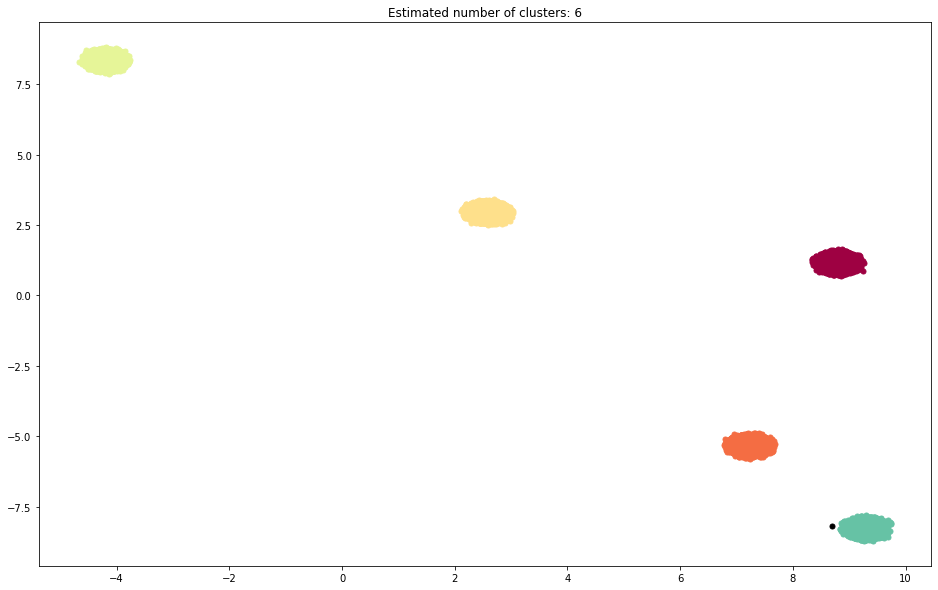

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(16, 10))

X = np.array(host_data)
labels = clustering_cuml.labels_.values

n_clusters_ = len(clustering_cuml.labels_.unique())


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markersize=5, markeredgecolor=tuple(col))

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [7]:
cuml_score = adjusted_rand_score(host_labels, clustering_cuml.labels_)
cuml_score

0.9999993750000781

## Evaluate Results

Use the `adjusted_rand_score` to compare the two results, making sure the clusters are labeled similarly by both algorithms even if the exact numerical labels are not identical. 

In [ ]:
%%time
cuml_score = adjusted_rand_score(host_labels, clustering_cuml.labels_)
sk_score = adjusted_rand_score(host_labels, clustering_sk.labels_)

In [ ]:
passed = (cuml_score - sk_score) < 1e-10
print('compare dbscan: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))